#Customer Segmentation with RFM Analysis
I will use a database of an E-commerce in Brazil. Looking at the data, we can see that we have infos from the date 2016-09-04 to 2018-10-17. Probably was an extration on October 2018.

You can download the SQL database in the link: [Click here to Download](https://www.kaggle.com/datasets/terencicp/e-commerce-dataset-by-olist-as-an-sqlite-database)

I will start the analysis trying to follow the RFM (Recency, Frequency, Monetary) Analysis described by Putler`s Blog in this post: [RFM Analysis For Successful Customer Segmentation](https://www.putler.com/rfm-analysis/)

We need a few details of each customer:


*   Customer ID / Email / Name etc: to identify them
*   Recency (R) as days since last purchase: How many days ago was their last purchase? Deduct the most recent purchase date from today to calculate the recency value.
*   Frequency (F) the as total number of transactions: How many times has the customer purchased from our store?
*   Monetary (M) as total money spent: How many $$ (or whatever is your currency of calculation) has this customer spent?




In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

If you are doing this for a professional purpose you can calculate all three indicators at once. Because this is a educational purpose, I am going to write it more detailed and make more comments.

##Recency (R): Days since last purchase

In [2]:
conn = sqlite3.connect('/content/drive/MyDrive/projectDatabase/olist.sqlite')
query = """
SELECT
c.customer_unique_id,
julianday('2018-10-17') - julianday( max(o.order_date)) AS difference_in_days, -- I am using the date that mest be the date of the extraction of the database
max(o.order_date) as last_date -- I will select this column just so we can validate the values

FROM customers c

join (select
            od.customer_id,
            od.order_purchase_timestamp as order_date
         from orders od
         where 1=1
         and  od.order_status in ('delivered','invoiced', 'shipped') -- Only orders that are 'confirmed'
         ORDER BY od.order_purchase_timestamp desc
         ) o on o.customer_id = c.customer_id

group by c.customer_unique_id
"""

dfR = pd.read_sql_query(query, conn)
conn.close()
dfR

,customer_unique_id,difference_in_days,last_date
0,0000366f3b9a7992bf8c76cfdf3221e2,159.544132,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,162.533715,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,585.121493,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,369.146053,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,336.176597,2017-11-14 19:45:42
...,...,...,...
94692,fffcf5a5ff07b0908bd4e2dbc735a684,495.124583,2017-06-08 21:00:36
94693,fffea47cd6d3cc0a88bd621562a9d061,310.161157,2017-12-10 20:07:56
94694,ffff371b4d645b6ecea244b27531430a,616.340787,2017-02-07 15:49:16
94695,ffff5962728ec6157033ef9805bacc48,167.362720,2018-05-02 15:17:41


##Frequency (F): Total number of transactions

In [3]:
conn = sqlite3.connect('/content/drive/MyDrive/projectDatabase/olist.sqlite')
query = """
SELECT
c.customer_unique_id,
count(distinct o.order_id) as number_of_transactions

FROM customers c

join (select
            od.customer_id,
            od.order_id
      from orders od
      where 1=1
            and  od.order_status in ('delivered','invoiced', 'shipped') -- Only orders that are 'confirmed'
         ) o on o.customer_id = c.customer_id

group by c.customer_unique_id
order by 2 desc;
"""

dfF = pd.read_sql_query(query, conn)
conn.close()
dfF

,customer_unique_id,number_of_transactions
0,8d50f5eadf50201ccdcedfb9e2ac8455,16
1,3e43e6105506432c953e165fb2acf44c,9
2,ca77025e7201e3b30c44b472ff346268,7
3,6469f99c1f9dfae7733b25662e7f1782,7
4,1b6c7548a2a1f9037c1fd3ddfed95f33,7
...,...,...
94692,0004aac84e0df4da2b147fca70cf8255,1
94693,0000f6ccb0745a6a4b88665a16c9f078,1
94694,0000f46a3911fa3c0805444483337064,1
94695,0000b849f77a49e4a4ce2b2a4ca5be3f,1


##Monetary (M): Total money spent

In [4]:
query = """
SELECT
c.customer_unique_id,
sum(o.payment_value) as total_value_of_transactions

FROM customers c
join (select
            od.customer_id,
            od.order_id,
            op.payment_value
      from orders od
      left join order_payments op on  od.order_id = op.order_id
      where 1=1
            and  od.order_status in ('delivered','invoiced', 'shipped') -- Only orders that are 'confirmed'
         ) o on o.customer_id = c.customer_id

group by c.customer_unique_id
order by 2 desc;
"""
conn = sqlite3.connect('/content/drive/MyDrive/projectDatabase/olist.sqlite')
dfM = pd.read_sql_query(query, conn)
conn.close()
dfM

,customer_unique_id,total_value_of_transactions
0,0a0a92112bd4c708ca5fde585afaa872,13664.08
1,da122df9eeddfedc1dc1f5349a1a690c,7571.63
2,763c8b1c9c68a0229c42c9fc6f662b93,7274.88
3,dc4802a71eae9be1dd28f5d788ceb526,6929.31
4,459bef486812aa25204be022145caa62,6922.21
...,...,...
94692,2878e5b88167faab17d4fb83a986d38b,11.63
94693,b33336f46234b24a613ad9064d13106d,10.89
94694,bd06ce0e06ad77a7f681f1a4960a3cc6,10.07
94695,317cfc692e3f86c45c95697c61c853a6,9.59


##Applying the RFM Score Formula

Now we set our Dataframe to the perfect state, we set the columns names, index, fill the nan values and the data types.

In [5]:
dfTotal = pd.merge(dfR, dfF, on='customer_unique_id')
dfTotal = pd.merge(dfTotal, dfM, on='customer_unique_id')
dfTotal.drop("last_date", axis= 1, inplace=True)
dfTotal.rename(columns={"difference_in_days":"R","number_of_transactions":"F", "total_value_of_transactions":"M"}, inplace=True)
dfTotal.fillna(0, inplace=True)
#dfTotal.set_index('customer_unique_id', inplace= True)
dfTotal["R"] = dfTotal["R"].astype(int)
dfTotal["M"] = dfTotal["M"].astype(int)
dfTotal

,customer_unique_id,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,159,1,141
1,0000b849f77a49e4a4ce2b2a4ca5be3f,162,1,27
2,0000f46a3911fa3c0805444483337064,585,1,86
3,0000f6ccb0745a6a4b88665a16c9f078,369,1,43
4,0004aac84e0df4da2b147fca70cf8255,336,1,196
...,...,...,...,...
94692,fffcf5a5ff07b0908bd4e2dbc735a684,495,1,2067
94693,fffea47cd6d3cc0a88bd621562a9d061,310,1,84
94694,ffff371b4d645b6ecea244b27531430a,616,1,112
94695,ffff5962728ec6157033ef9805bacc48,167,1,133


Now we calculate the score for each indicator. We rank the values and set it from 1 (worst score) to 5 (Best score).

In [6]:
def set_score(df, col='R'):
    total_rows = len(df)
    target_count_per_score = (total_rows / 5) # to see how many rows will have the same score
    if col == 'R': # Test which column are you going to sort it
        df = df.sort_values(by=col, ascending=False)
    else:
        df = df.sort_values(by=col, ascending=True)

    col = col + ' Score'
    score = 1
    group_size = -(-target_count_per_score // 1)  # Round up using integer division and negation
    group_count = 0
    scores = []
    for index, row in df.iterrows():
        scores.append(score)
        group_count = group_count + 1
        if group_count == group_size:
            score = score + 1
            group_count = 0

    df[col] = scores


    return df

In [7]:
dfTotal = set_score(dfTotal,col='R')
dfTotal = set_score(dfTotal,col='F')
dfTotal = set_score(dfTotal,col='M')

In [8]:
dfTotal['Total Score'] = dfTotal['F Score'].astype(str) + dfTotal['M Score'].astype(str) + dfTotal['R Score'].astype(str)
dfTotal['Total Score'] = dfTotal['Total Score'].astype(int)
dfTotal = dfTotal.sort_values(by='Total Score', ascending=False)
dfTotal

,customer_unique_id,R,F,M,R Score,F Score,M Score,Total Score
5553,0ef7b906320b21fe4d39f99496aaa2d8,73,2,210,5,5,5,555
40749,6dcf48fcc0c4d96dd7af8a0897ae9de8,91,2,447,5,5,5,555
79916,d7bf7cfe09c3d0f40e1cabde2dc17fd4,110,2,358,5,5,5,555
63055,aa3bf249b773d47a88cd191c16152086,110,2,301,5,5,5,555
54097,9263a6fc47a37b8b71cecfeb1defda4a,87,2,387,5,5,5,555
...,...,...,...,...,...,...,...,...
22669,3d1d4c2d55117aced1b69276d407085b,264,1,22,3,1,1,113
34641,5d3c91f347dbd8a49ba30528baa5d448,265,1,45,3,1,1,113
25357,4470b161249e3d1bd1ab07b4c0e3f15f,270,1,55,3,1,1,113
17352,2eb487827f6a81edd6266b9db2413abc,228,1,45,3,1,1,113


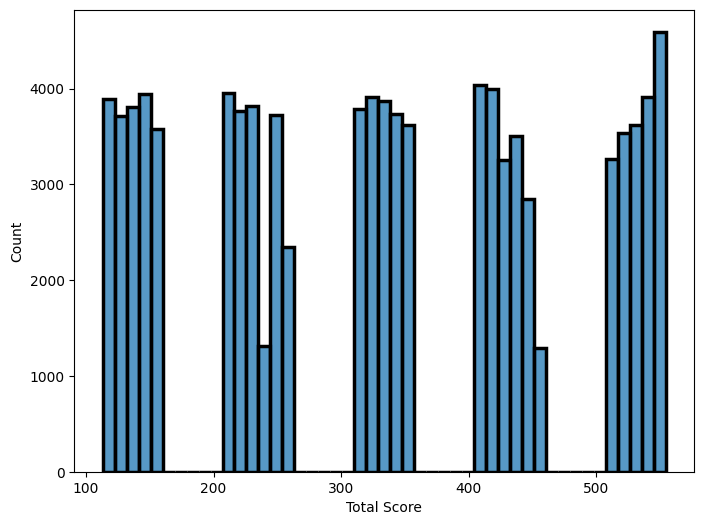

In [9]:
plt.figure(figsize=(8, 6))
sns.histplot(dfTotal['Total Score'], linewidth=2.5)
plt.show()

In [12]:
dfTotal

,customer_unique_id,R,F,M,R Score,F Score,M Score,Total Score
5553,0ef7b906320b21fe4d39f99496aaa2d8,73,2,210,5,5,5,555
40749,6dcf48fcc0c4d96dd7af8a0897ae9de8,91,2,447,5,5,5,555
79916,d7bf7cfe09c3d0f40e1cabde2dc17fd4,110,2,358,5,5,5,555
63055,aa3bf249b773d47a88cd191c16152086,110,2,301,5,5,5,555
54097,9263a6fc47a37b8b71cecfeb1defda4a,87,2,387,5,5,5,555
...,...,...,...,...,...,...,...,...
22669,3d1d4c2d55117aced1b69276d407085b,264,1,22,3,1,1,113
34641,5d3c91f347dbd8a49ba30528baa5d448,265,1,45,3,1,1,113
25357,4470b161249e3d1bd1ab07b4c0e3f15f,270,1,55,3,1,1,113
17352,2eb487827f6a81edd6266b9db2413abc,228,1,45,3,1,1,113


##RFM Matrix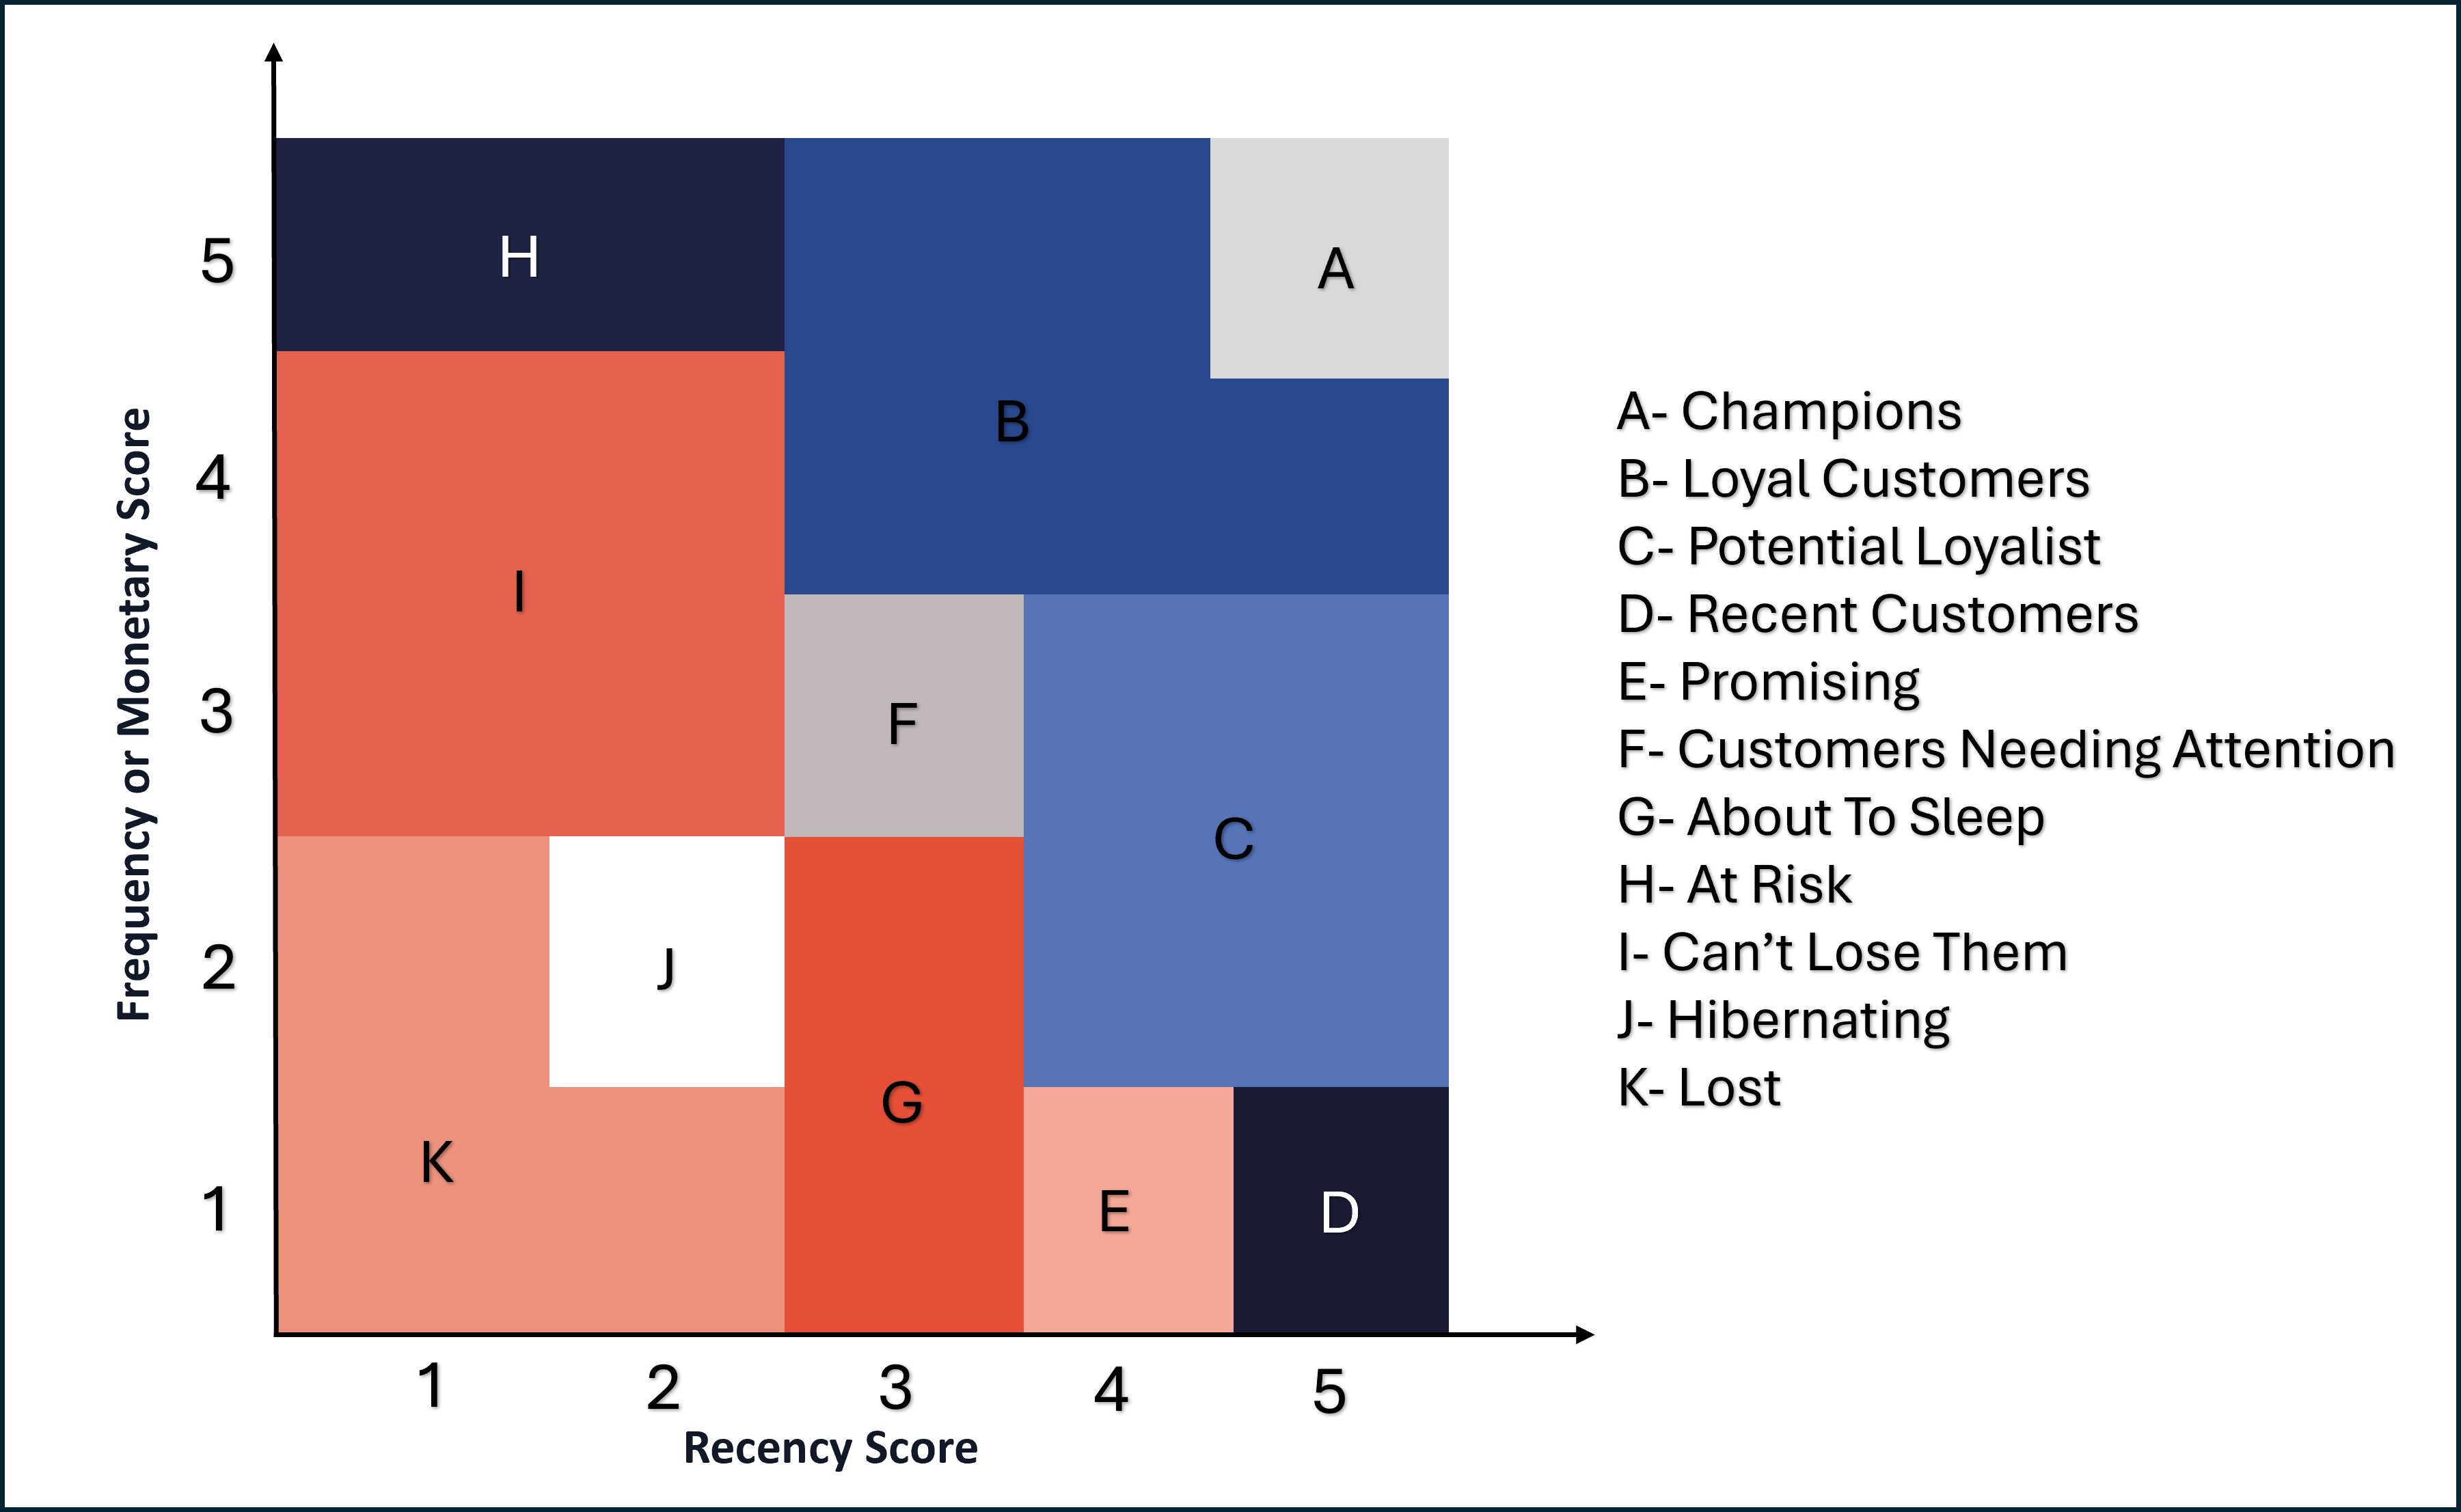

Now we are trying to plot the matrix of our customer segmentation from ther RFM Analysis. The classification has 11 groups of customers.

You can see an adaptation of the matrix classification in this image. I used the matrix in this brazilian blog and tanslated back to english. [Blog G4 Educação](https://g4educacao.com/portal/o-que-e-matriz-rfm)

In [13]:
df_grouped = dfTotal[["R Score","M Score","customer_unique_id"]].pivot_table(index =["M Score"], columns=["R Score"] , values="customer_unique_id" , aggfunc='count')
df_grouped

R Score,1,2,3,4,5
M Score,,,,,
1,3987,3595,3918,3668,3772
2,4012,4093,3716,3559,3560
3,3722,3736,3766,3877,3839
4,3454,3689,3927,3962,3908
5,3765,3827,3613,3874,3858


In [15]:
df_grouped[[1,2,3,4,5]]

R Score,1,2,3,4,5
M Score,,,,,
1,3987,3595,3918,3668,3772
2,4012,4093,3716,3559,3560
3,3722,3736,3766,3877,3839
4,3454,3689,3927,3962,3908
5,3765,3827,3613,3874,3858


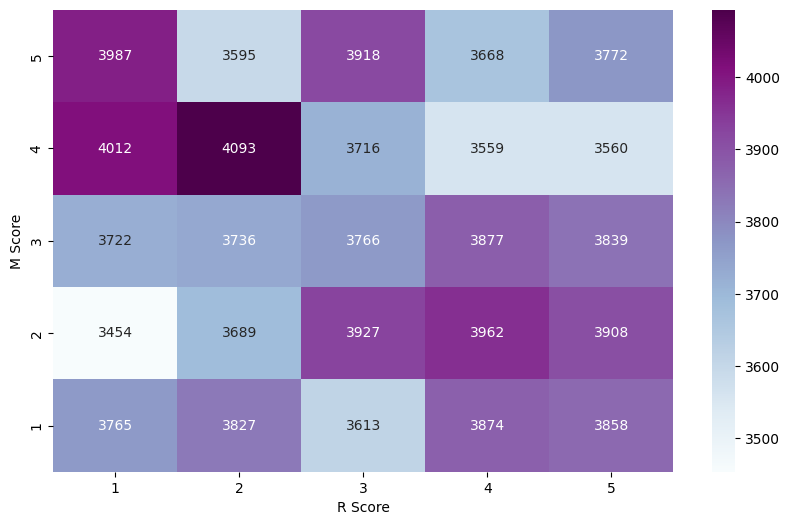

In [26]:
#df_grouped = dfTotal.pivot(index =["R Score"], columns=["M Score"] )
#df_grouped = df_grouped.groupby('R Score')
#df_grouped = df_grouped.pivot_table(index ='R Score' , values='M Score', aggfunc='nunique'  )
plt.figure(figsize=(10, 6))
sns.heatmap( df_grouped, xticklabels= df_grouped.index, yticklabels= df_grouped[[5,4,3,2,1]]  , annot=True, fmt='d', cmap= 'BuPu' )
plt.show()